# Imports and Load Data

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_pickle("../data/df_clean.pkl")

# Data cleaning & feature engineering

In [35]:
# basic checks
df = df.drop_duplicates(subset=['appointment_id'])

In EDA we identified outliers and removed them, for this exercise we need to clean the data on a deeper level in order to pass it to the ML models

## Drop unwanted features

We start by removing unwanted feature either becuase they are redundant or because they are not informative nor discriminative like tenant and status (low variance variables)

In [36]:
drop_cols = [
    'appointment_id','tenant','status',
    'recurrence_24hours','recurrence_48hours','recurrence_7days',
    'updated_at','end_time','started_at','finished_at','created_at','process_date'
    'recommendation_rating','appointment_classification','appointment_helpful','in_person_appointment_evaluation',
    'icd_code2','icd_code3'
]

# ---- Drop irrelevant columns ----
df = df.drop(columns=drop_cols, errors='ignore').copy()

Now lets encode the target variable

In [37]:
# ---- Target variable first ----
map_dict = {
    'yes': 1, 'y': 1, 'true': 1, '1': 1, 'sim': 1,
    'no': 0, 'n': 0, 'false': 0, '0': 0, 'nao': 0, 'não': 0
}
s_norm = df['recurrence_72hours'].astype(str).str.strip().str.lower()
s_norm = s_norm.replace({'nan': pd.NA, 'none': pd.NA, '': pd.NA})
mapped = s_norm.map(map_dict)
df['y'] = mapped.astype('Int64')

## Feature engineering

We are now left with several features that need further processing like the 'patient_age_at_appointment' which can be binned in order to reduce dimensionality and handle missing value with need of impute

In [38]:
# ----  Age bin ----
def age_bin(a):
    if pd.isna(a): return 'unknown'
    a = int(a)
    if a < 18: return '<18'
    if a < 30: return '18-29'
    if a < 45: return '30-44'
    if a < 65: return '45-64'
    return '65+'

df['age_group'] = df['patient_age_at_appointment'].apply(age_bin)

# Drop the raw age column (we'll use only age_group)
df = df.drop(columns=['patient_age_at_appointment'])

Week cycles are important information hat can be extracted from the 'start_time' date

In [39]:
# ---- Basic temporal features ----
df['start_weekday'] = df['start_time'].dt.weekday
df['is_weekend'] = df['start_weekday'].isin([5,6]).astype(int)

df = df.drop(columns=['start_time'], errors='ignore')

# Drop start_weekday since we decided to test only with is_weekend
df = df.drop(columns=['start_weekday'])

We took out 'icd_code2'and 'icd_code3' because of missing values but 'icd_code1' can have valuable information. Because there are several unique values for this variable we must find a way to not introduce to many dimensions. One solution is to keep the most frequent codes and bin the rest

In [40]:
# ---- ICD encoding (keep only icd_code1) ----
df['icd_code1'] = df['icd_code1'].fillna('none')

# Fix weird placeholder entries
df['icd_code1'] = df['icd_code1'].replace({'icd_': 'other'})

# Identify top 10 ICD codes (excluding 'none' and 'other')
top_icd = df['icd_code1'][~df['icd_code1'].isin(['none', 'other'])].value_counts().nlargest(10).index

# One-hot encode top 10
for icd in top_icd:
    df[f'icd_{icd}'] = (df['icd_code1'] == icd).astype(int)

# Group the rest into "icd_other" (includes 'other' placeholder)
df['icd_other'] = (~df['icd_code1'].isin(top_icd) & (df['icd_code1'] != 'none')).astype(int)

In [41]:
# Count top 10 ICD codes + other
icd_cols = [f'icd_{icd}' for icd in top_icd] + ['icd_other']
icd_counts = df[icd_cols].sum().sort_values(ascending=False)
print("ICD code counts (number of patients with each code):")
print(icd_counts)


ICD code counts (number of patients with each code):
icd_other     75242
icd_Z76.0     20884
icd_          17416
icd_J03.90     7082
icd_J00        6193
icd_J06.9      4503
icd_R05        3631
icd_K52.9      3533
icd_N30.00     2814
icd_U07.1      2615
icd_J01.90     2477
dtype: int64


Cleaning up other categorical variables

In [42]:
# ---- 6) Categorical reductions ----

# Clean patient sex (map random / missing to 'missing')
df['patient_sex'] = (
    df['patient_sex']
    .replace({'': 'missing', ' ': 'missing'})   # blank/empty to missing
    .fillna('missing')
    .astype(str)
)


cat_cols = ['service_type','patient_sex','age_group']
for c in cat_cols:
    df[c] = df[c].fillna('missing').astype(str)


I choose not to delete collumns with missing values in order to preserve the integrity of the data. We would need to make sure that the imbalanced class of the target is not to affected by ther deletion. Also imputing the values could be a solution for numerical vareiables.

## Feature Selection

Now we can take a deeper look at the relashionship between features and target variable.

Correlation with target (y):
delay_minutes       0.029821
duration_minutes   -0.021235
realization_sla    -0.027236
dtype: float64


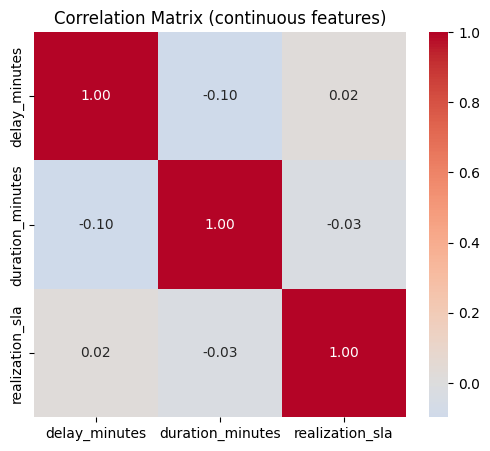

In [43]:
# ---- Continuous features to check ----
# (exclude raw age, keep age_group categorical instead)
num_cols = [
    'delay_minutes',
    'duration_minutes',
    'realization_sla'
]

# Correlation with target
corrs = df[num_cols].corrwith(df['y'])
print("Correlation with target (y):")
print(corrs.sort_values(ascending=False))

# Redundancy among continuous variables
plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix (continuous features)")
plt.show()



There seems to be no great redundancy and also not to much correlation with the target variable, for that reason these features are going to be selected for model training

In [44]:


cat_cols = ['service_type','patient_sex','age_group','is_weekend']

for col in cat_cols:
    ct = pd.crosstab(df[col], df['y'])
    chi2_stat, p, dof, expected = chi2_contingency(ct)
    print(f"\nChi-square test for {col}")
    print(ct)
    print(f"Chi2 = {chi2_stat:.2f}, dof = {dof}, p-value = {p:.4f}")
    print("Mean target rate by category:")
    print(df.groupby(col)['y'].mean())





Chi-square test for service_type
y                 0      1
service_type              
phone         73605  10578
remote        85705   7838
Chi2 = 835.61, dof = 1, p-value = 0.0000
Mean target rate by category:
service_type
phone     0.125655
remote     0.08379
Name: y, dtype: Float64

Chi-square test for patient_sex
y                0      1
patient_sex              
F            95720  11119
M            54292   6723
missing       9298    574
Chi2 = 248.36, dof = 2, p-value = 0.0000
Mean target rate by category:
patient_sex
F          0.104072
M          0.110186
missing    0.058144
Name: y, dtype: Float64

Chi-square test for age_group
y              0     1
age_group             
18-29      31169  3693
30-44      39985  3854
45-64      36432  3553
65+        25518  3265
<18        25257  4000
unknown      949    51
Chi2 = 617.02, dof = 5, p-value = 0.0000
Mean target rate by category:
age_group
18-29      0.105932
30-44      0.087913
45-64      0.088858
65+        0.113435
<18   

p value is is very low (<0.05) which makes these good candidates to keep for model training

In [45]:
icd_target_rate = {}
for col in icd_cols:
    # target rate = recurrence among patients with this ICD
    icd_target_rate[col] = df.loc[df[col]==1, 'y'].mean()

icd_target_rate = pd.Series(icd_target_rate).sort_values(ascending=False)
print("\nTarget rate by ICD code:")
print(icd_target_rate)



Target rate by ICD code:
icd_R05       0.150647
icd_          0.144178
icd_J06.9     0.125028
icd_J00       0.117229
icd_other     0.097685
icd_J03.90    0.093900
icd_K52.9     0.082083
icd_U07.1     0.075335
icd_Z76.0     0.068761
icd_J01.90    0.067420
icd_N30.00    0.058280
dtype: float64


Some diagnoses are clearly higher risk for 72h recurrence

In [46]:


print("\nChi-square test for ICD codes:")
for col in icd_cols:
    ct = pd.crosstab(df[col], df['y'])
    chi2_stat, p, dof, expected = chi2_contingency(ct)
    print(f"{col}: Chi2={chi2_stat:.2f}, p={p:.4f}")


Chi-square test for ICD codes:
icd_Z76.0: Chi2=309.18, p=0.0000


icd_: Chi2=341.45, p=0.0000
icd_J03.90: Chi2=7.39, p=0.0065
icd_J00: Chi2=12.64, p=0.0004
icd_J06.9: Chi2=22.56, p=0.0000
icd_R05: Chi2=87.74, p=0.0000
icd_K52.9: Chi2=17.77, p=0.0000
icd_N30.00: Chi2=62.79, p=0.0000
icd_U07.1: Chi2=22.55, p=0.0000
icd_J01.90: Chi2=35.05, p=0.0000
icd_other: Chi2=49.38, p=0.0000


## Data Imbalance Handling

We are going to do a simple partial undersampling (which is still very extreme). There are other resampling, undersamplind and oversampling techniques that could be tested

In [47]:


# 1) Split first (without one-hot encoding)
X = df.drop(columns=['y'])
y = df['y']

mask = y.notna()
X = X[mask]
y = y[mask]

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Partial undersampling
minority_count = y_train.value_counts()[1]
target_majority = 2 * minority_count
sampling_strategy = {0: target_majority, 1: minority_count}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print("Target counts AFTER partial undersampling:")
print(y_train_res.value_counts())


Target counts AFTER partial undersampling:
y
0    29466
1    14733
Name: count, dtype: Int64


In [48]:
numeric_features = ['realization_sla', 'duration_minutes', 'delay_minutes', 'is_weekend']
# Keep original categorical features
cat_features = ['service_type','patient_sex','age_group']

# Add only “valid” ICD one-hot columns
icd_cols = [c for c in X_train_res.columns if c.startswith('icd_') 
            and c not in ['icd_code1', 'icd_', 'icd_none']]

cat_features += icd_cols


# Modelling

I choose 3 models that work well with tabular data and have complementary strengths, specially when dealing with unbalanced datasets:

Logistic Regression: Baseline & interpretable.
Random Forest: Non-linear baseline, robust to overfitting.
XGBoost: High-performance, captures complex patterns.

In [49]:
# --- 2) Preprocessing pipelines ---
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preproc = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, cat_features)
])

# --- 3) Models ---
models = {
    'logreg': LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1),
    'rf': RandomForestClassifier(
        n_estimators=200,  # reduced for speed
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    'xgb': XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=(y_train_res==0).sum() / (y_train_res==1).sum(),
        n_jobs=-1,
        use_label_encoder=False  # remove deprecated param
    )
}

# --- 4) Cross-validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 5) Fit and evaluate ---
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score

# --- 1) Fit pipelines on undersampled train ---
fitted_pipelines = {}
for name, clf in models.items():
    pipe = Pipeline([('pre', preproc), ('clf', clf)])
    pipe.fit(X_train_res, y_train_res)
    fitted_pipelines[name] = pipe

# --- 2) Evaluate on original test set ---
for name, pipe in fitted_pipelines.items():
    y_pred_prob = pipe.predict_proba(X_test)[:, 1]  # probability for positive class
    ap = average_precision_score(y_test, y_pred_prob)
    roc = roc_auc_score(y_test, y_pred_prob)
    print(f"{name} on original test set - AP: {ap:.4f}, ROC-AUC: {roc:.4f}")



c:\Users\Mariana Saavedra\Desktop\Case_Study_Mariana\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [13:06:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


logreg on original test set - AP: 0.1552, ROC-AUC: 0.6228
rf on original test set - AP: 0.1382, ROC-AUC: 0.5904
xgb on original test set - AP: 0.1517, ROC-AUC: 0.6081


AP scores are quite low. This is expected for a highly imbalanced dataset, even after undersampling, the models still struggle to rank the positive class correctly. Also, the models only saw a subset of majority-class data during training.
That’s why AP is low on the full dataset.